A_ut shape: torch.Size([25600, 16384])
x shape: torch.Size([2, 128, 128])
y shape: torch.Size([25600])
y reshaped to: torch.Size([128, 200])
0.0786469210973844


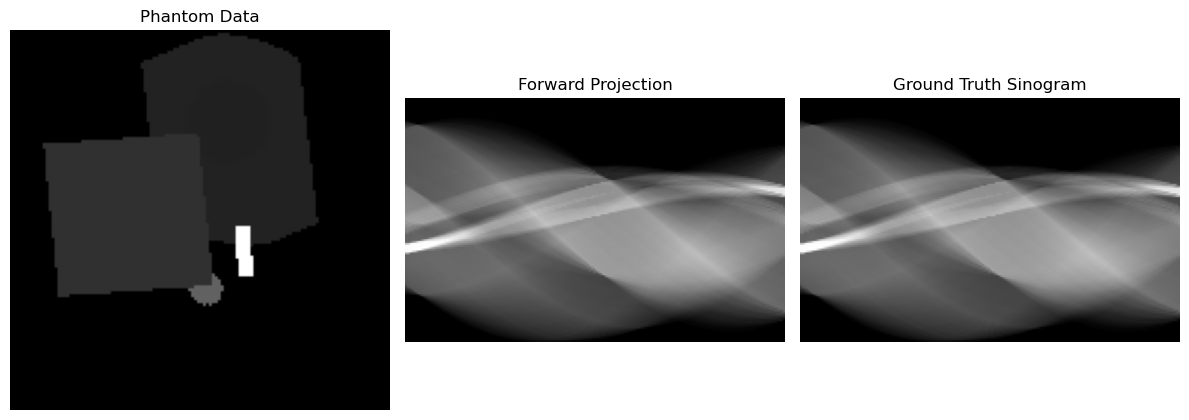

x_reconstructed shape: torch.Size([128, 128])


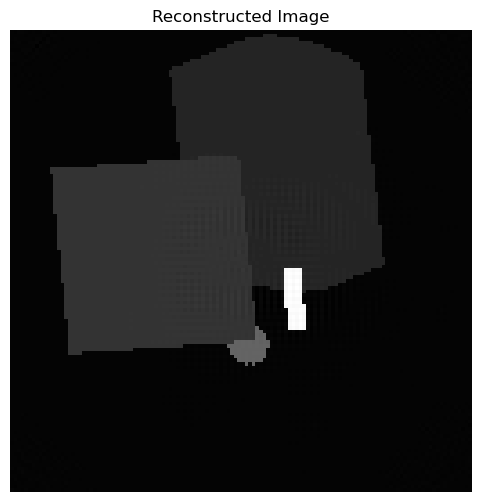

Min/Max of Phantom: 0.0/2.705002592622282e+24
Min/Max of Forward Projection: 0.0/0.0002705008373595774
Min/Max of Ground Truth Sinogram: 0.0/3.05711322710343e-05
Min/Max of Reconstructed Image: -4.818923658880469e+22/2.7534137666007234e+24


In [ ]:
# Load the A_ut A_ub and A_tb matrices from the file and test them on forward projections of our phantom data

import numpy as np
import sys
import os
import matplotlib.pyplot as plt

import torch

data_folder: str = '../data_discretised/'

A_ut: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_ut.npy')
#A_ub: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_ub.npy')
#A_tb: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_tb.npy')

A_ut = A_ut.astype(np.float32)
#A_ub = A_ub.astype(np.float32)
#A_tb = A_tb.astype(np.float32)

A_ut = torch.tensor(A_ut).cuda()  # Move to GPU if available
#A_ub = torch.tensor(A_ub).cuda()  # Move to GPU if available
#A_tb = torch.tensor(A_tb).cuda()  # Move to GPU if available

print(f'A_ut shape: {A_ut.shape}')
#print(f'A_ub shape: {A_ub.shape}')
#print(f'A_tb shape: {A_tb.shape}')

# Load the phantom data
x: np.ndarray | torch.Tensor = np.load(os.path.join(data_folder, 'phan-96.npy'))
x = torch.tensor(x).cuda()  # Move to GPU if available

gt_sino: np.ndarray | torch.Tensor = np.load(os.path.join(data_folder, 'sino-96.npy'))
gt_sino = torch.tensor(gt_sino).cuda()  # Move to GPU if available

print(f'x shape: {x.shape}')

# Forward projection
y: torch.Tensor = A_ut @ x[0].ravel() #np.sum(x, axis=0).ravel()

print(f'y shape: {y.shape}')
y = y.reshape((128, -1))
print(f'y reshaped to: {y.shape}')

print(f'{torch.sum(y - torch.sum(gt_sino, axis=-1)).item()}')

# Plot the Phantom Data, Forward projection, and Ground Truth Sinogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(x[0].cpu().numpy(), cmap='gray')
plt.title('Phantom Data')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(y.cpu().numpy(), cmap='gray')
plt.title('Forward Projection')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.sum(gt_sino, axis=-1).cpu().numpy(), cmap='gray')
plt.title('Ground Truth Sinogram')
plt.axis('off')
plt.tight_layout()
plt.show()

A_ut_pinv: torch.Tensor = torch.linalg.pinv(A_ut)


# Try applying the transpose of the matrix to the sinogram
x_reconstructed: torch.Tensor = A_ut_pinv @ y.ravel()
x_reconstructed = x_reconstructed.reshape((128, -1))
print(f'x_reconstructed shape: {x_reconstructed.shape}')
x_reconstructed = x_reconstructed.reshape(x[0].shape)
# Plot the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(x_reconstructed.cpu().numpy(), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

# Print min and max vaues of original phantom, forward projection, original sinogram, and reconstructed image
print(f'Min/Max of Phantom: {torch.min(x[0])}/{torch.max(x[0])}')
print(f'Min/Max of Forward Projection: {torch.min(y)}/{torch.max(y)}')
print(f'Min/Max of Ground Truth Sinogram: {torch.min(gt_sino)}/{torch.max(gt_sino)}')
print(f'Min/Max of Reconstructed Image: {torch.min(x_reconstructed)}/{torch.max(x_reconstructed)}')


In [ ]:
print(f'A_ut_pinv shape: {A_ut_pinv.shape}')

# Save the pinv matrix as numpy file
np.save(f'{data_folder}A_ut_pinv.npy', A_ut_pinv.cpu().numpy())

# Let's compute the residual between x_reconstructed and the original phantom
residual: torch.Tensor = x_reconstructed - x[0]

print(f'Residual (MAE): {torch.mean(torch.abs(residual)).item()}')

# Plot the residual
plt.figure(figsize=(6, 6))
plt.imshow(residual.cpu().numpy(), cmap='gray')
plt.title('Residual Image')
plt.axis('off')
plt.show()
